In [1]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [2]:
#"""此note book为股票回测框架的示例"""

In [3]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
from BackTestingEngine import backTestingEngine as bte
#from config import *

In [5]:
path = ff.data_path

In [6]:
startTime =  datetime.strptime('20120504', '%Y%m%d')
endTime = datetime.strptime('20170928', '%Y%m%d')
initstartTime =  datetime.strptime('20120304', '%Y%m%d')
initendTime = datetime.strptime('20170928', '%Y%m%d')

In [7]:
filenameAdjOpen = 'OwnfactorAdjustedOpen.h5'
filenameAdjClose = 'OwnfactorAdjustedClose.h5'
filenameVolume = 'LZ_CN_STKA_QUOTE_TVOLUME.h5'

In [8]:
# 初始化
test = bte.StkBacktesting(path)

In [9]:
test.setInitCap(5000000)
test.availableCashNow

5000000

In [10]:
# 添加数据
test.addData('adjOpen',filenameAdjOpen)
test.addData('adjClose',filenameAdjClose)
test.addData('volume',filenameVolume)

In [11]:
# 截取回测区间和初始化区间
test.setBackTestingPeriod(startTime,endTime)
test.setInitialPeriod(initstartTime,initendTime)

In [12]:
# 双均线筛选买卖股
ma5 = test.dataDict['adjClose'].rolling(window=5, min_periods=5).mean()
ma20 = test.dataDict['adjClose'].rolling(window=20, min_periods=20).mean()
buyStk = ((ma5 > ma20) & ((ma5 < ma20).shift(1) )).shift(1).loc[test.backTestingDateList.tolist()]
sellStk = ((ma5 < ma20) & ((ma5 > ma20).shift(1) )).shift(1).loc[test.backTestingDateList]

In [13]:
endofMonth = sorted(list(set(buyStk .iloc[buyStk .resample('M').size().cumsum().sub(1)].index)))

In [14]:
# 按天循环
for date in  test.backTestingDateList:
    if date in endofMonth:
        #todayindex = test.backTestingDateList.tolist().index(date)
        #yesterday = test.backTestingDateList[todayindex -1]
        #print yesterday

        # 切片确定当天的买卖股票
        sellslice = sellStk.loc[date]
        sellList = sellslice.loc[sellslice==True].index.tolist()
        #print 'before',len(sellList)
        buyslice = buyStk.loc[date]
        buyList = buyslice.loc[buyslice==True].index.tolist()
        # 买卖单
        buyOrders = [test.makeOrder(date,stkID,100,20,1) for stkID in buyList]

        # 区分有无持仓时，只有有持仓时才可以卖，并且顺序永远是先卖后买   
        if test.getCurrentPosition():

            print date, 'Current position Num',len(test.getCurrentPosition())

            sellList = list(set(sellList) & set(test.getCurrentPosition().keys()))
            sellOrders = [test.makeOrder(date,stkID,test.getCurrentPosition()[stkID].volume,20,-1) for stkID in sellList]
            totalOrders = sellOrders + buyOrders
            #print 'buyNumber',len(buyOrders)
            #print 'sellNumber', len(sellList)
        else:
            #print 'Current position is 0'
            totalOrders = buyOrders
        #print len(totalOrders)
        if totalOrders:  
            test.allOrdersDict[date] = totalOrders  # 保存order到字典里
            test.crossOrder(date)     #  撮合
            test.updateHoldingInfo(date)
        else:  # 若当日无订单则直接更新持仓
            test.updateHoldingInfo(date)   # 不管当日是否交易此方法必须每次调用
        #print date,'Wrong one', test.getAllPosition()[date].__len__()
        #print date,'compare',len(test.getCurrentPosition())
        #try:
        #    print yesterday,'yester',test.getAllPosition()[yesterday].__len__()
        #except:
         #   pass
    else:
        # 每日更新市值
        test.updateHoldingInfo(date)

2012-06-29 00:00:00 Current position Num 65
2012-07-31 00:00:00 Current position Num 73
2012-08-31 00:00:00 Current position Num 101
2012-09-28 00:00:00 Current position Num 95
2012-10-31 00:00:00 Current position Num 119
2012-11-30 00:00:00 Current position Num 111
2012-12-31 00:00:00 Current position Num 121
2013-01-31 00:00:00 Current position Num 131
2013-02-28 00:00:00 Current position Num 187
2013-03-29 00:00:00 Current position Num 190
2013-04-26 00:00:00 Current position Num 202
2013-05-31 00:00:00 Current position Num 303
2013-06-28 00:00:00 Current position Num 316
2013-07-31 00:00:00 Current position Num 336
2013-08-30 00:00:00 Current position Num 320
2013-09-30 00:00:00 Current position Num 356
2013-10-31 00:00:00 Current position Num 368
2013-11-29 00:00:00 Current position Num 377
2013-12-31 00:00:00 Current position Num 406
2014-01-30 00:00:00 Current position Num 509
2014-02-28 00:00:00 Current position Num 595
2014-03-31 00:00:00 Current position Num 535
2014-04-30 00

In [15]:
#for i,j in test._allCurrentPositionDict.iteritems():
#    print i,j.values

In [16]:
positiondf = pd.DataFrame.from_dict(test.getAllPosition(), orient='index').reindex(test.backTestingDateList).fillna('ffill')

In [17]:
def converToVolume(holdingclass):
    try:
        volume = holdingclass.volume
    except:
        volume = np.NaN
    return volume

In [18]:
positiondf.applymap(converToVolume).fillna(0).tail(10)

,600507.SH,603001.SH,300039.SZ,600190.SH,600501.SH,600586.SH,002474.SZ,000895.SZ,300192.SZ,600562.SH,...,002415.SZ,002550.SZ,603368.SH,601336.SH,600084.SH,600228.SH,600209.SH,600064.SH,601388.SH,000812.SZ
date,,,,,,,,,,,,,,,,,,,,,
2017-09-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
pd.DataFrame.from_dict(test.tradingPnlDict, orient='index').tail()

,000031.SZ,000635.SZ,600216.SH,601318.SH,600056.SH,600168.SH,000002.SZ,000729.SZ,300252.SZ,000513.SZ,...,600577.SH,300106.SZ,002293.SZ,600734.SH,000981.SZ,600054.SH,000040.SZ,600676.SH,600423.SH,002430.SZ
2017-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2017-11-15 16:42:16.086000	期末净值：	1.1725
2017-11-15 16:42:16.087000	总盈亏：	862,445.1845
2017-11-15 16:42:16.088000	年化收益率：	0.0306
2017-11-15 16:42:16.088000	年化波动率：	0.0918
2017-11-15 16:42:16.088000	夏普比率：	0.3335
2017-11-15 16:42:16.088000	最大回撤: 	0.2612
2017-11-15 16:42:16.088000	胜率: 	0.691
2017-11-15 16:42:16.088000	换手率: 	0.0066
2017-11-15 16:42:16.089000	总手续费: 	23,296.5155


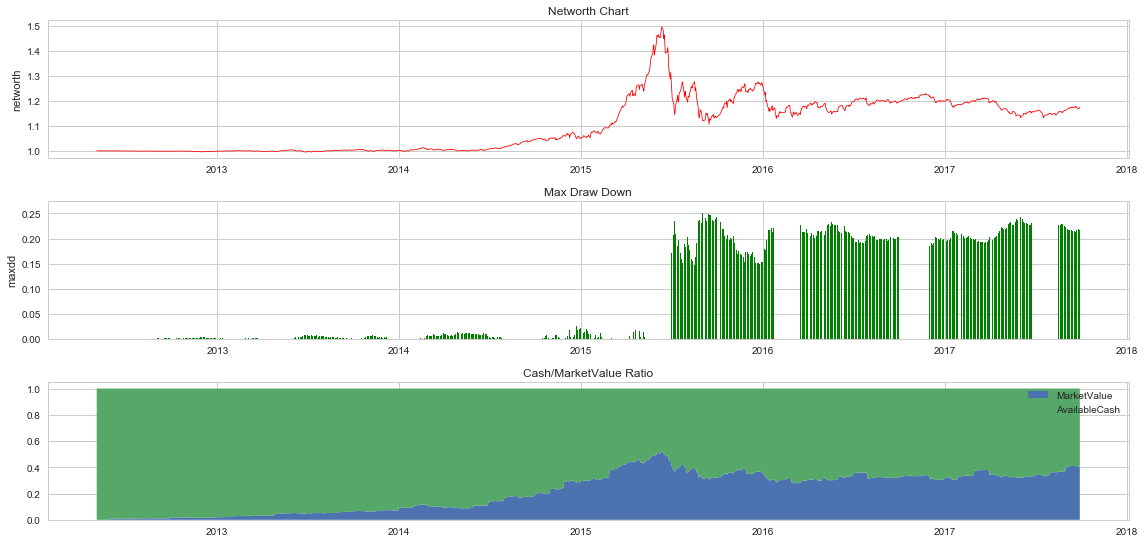

In [20]:
test.showBackTestingResult()

In [24]:
a =pd.Series(test.totalTradingAmountDict).reindex(test.backTestingDateList).fillna(0)

In [25]:
b =pd.Series(test.totalMarketValueDict).reindex(test.backTestingDateList).fillna(method ='ffill')